Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 15 Making Decisions in Complex Environments with Reinforcement Learning

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)

# Setting up the working environment

## Installing OpenAI Gym 

In [1]:
import gymnasium as gym
print(gym.envs.registry.keys())


dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0'])


# Solving the FrozenLake environment with dynamic programming

## Simulating the FrozenLake environment

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
 
n_state = env.observation_space.n
print(n_state)
n_action = env.action_space.n
print(n_action)


16
4


In [3]:
env.reset(seed=0)

(0, {'prob': 1})

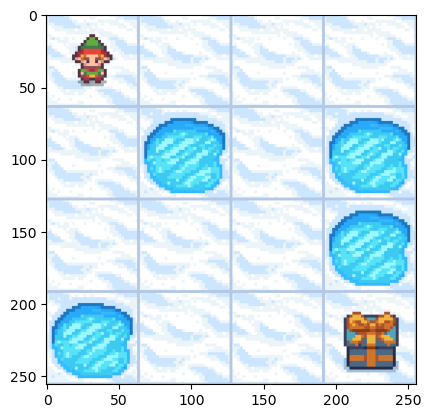

In [4]:
import matplotlib.pyplot as plt
plt.imshow(env.render())  


In [5]:
new_state, reward, terminated, truncated, info = env.step(2)
is_done = terminated or truncated
    
env.render()
print(new_state)
print(reward)
print(is_done)
print(info)

4
0.0
False
{'prob': 0.3333333333333333}


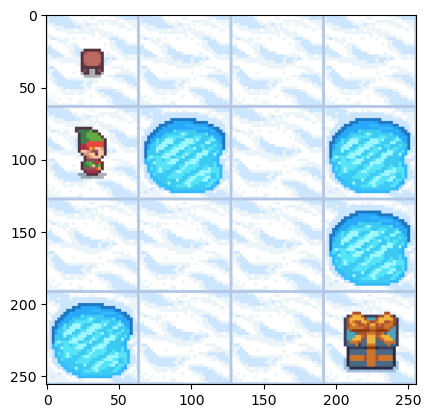

In [6]:
plt.imshow(env.render())

In [7]:
def run_episode(env, policy):
    state, _ = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        total_reward += reward
        if is_done:
            break
    return total_reward


In [8]:
import torch

n_episode = 1000

total_rewards = []
for episode in range(n_episode):
    random_policy = torch.randint(high=n_action, size=(n_state,))
    total_reward = run_episode(env, random_policy)
    total_rewards.append(total_reward)

print(f'Average total reward under random policy: {sum(total_rewards)/n_episode}')


Average total reward under random policy: 0.021


In [9]:
print(env.env.P[6])

{0: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 10, 0.0, False)], 1: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 7, 0.0, True)], 2: [(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 7, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 3: [(0.3333333333333333, 7, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 5, 0.0, True)]}


/home/oreo/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


## Solving FrozenLake with the value iteration algorithm

In [10]:
def value_iteration(env, gamma, threshold):
    """
    Solve a given environment with value iteration algorithm
    @param env: Gymnasium environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the optimal policy for the given environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.empty(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                    v_actions[action] += trans_prob * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V


In [11]:
gamma = 0.99
threshold = 0.0001

V_optimal = value_iteration(env, gamma, threshold)
print('Optimal values:\n', V_optimal)



Optimal values:
 tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])


In [12]:
def extract_optimal_policy(env, V_optimal, gamma):
    """
    Obtain the optimal policy based on the optimal values
    @param env: Gymnasium environment
    @param V_optimal: optimal values
    @param gamma: discount factor
    @return: optimal policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    optimal_policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V_optimal[new_state])
        optimal_policy[state] = torch.argmax(v_actions)
    return optimal_policy

In [13]:
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)
print('Optimal policy:\n', optimal_policy)

Optimal policy:
 tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


In [14]:
def run_episode(env, policy):
    state, _ = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        total_reward += reward
        if is_done:
            break
    return total_reward


n_episode = 1000
total_rewards = []
for episode in range(n_episode):
    total_reward = run_episode(env, optimal_policy)
    total_rewards.append(total_reward)

print('Average total reward under the optimal policy:', sum(total_rewards) / n_episode)

Average total reward under the optimal policy: 0.738


## Solving FrozenLake with the policy iteration algorithm

In [15]:
def policy_evaluation(env, policy, gamma, threshold):
    """
    Perform policy evaluation
    @param env: Gymnasium  environment
    @param policy: policy matrix containing actions and their probability in each state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the given policy
    """
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = policy[state].item()
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                V_temp[state] += trans_prob * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

In [16]:
def policy_improvement(env, V, gamma):
    """
    Obtain an improved policy based on the values
    @param env: Gymnasium  environment
    @param V: policy values
    @param gamma: discount factor
    @return: the policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

In [17]:
def policy_iteration(env, gamma, threshold):
    """
    Solve a given environment with policy iteration algorithm
    @param env: Gymnasium  environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: optimal values and the optimal policy for the given environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(env, policy, gamma, threshold)
        policy_improved = policy_improvement(env, V, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

In [18]:
gamma = 0.99
threshold = 0.0001


V_optimal, optimal_policy = policy_iteration(env, gamma, threshold)
print('Optimal values:\n', V_optimal)
print('Optimal policy:\n', optimal_policy)


Optimal values:
 tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])
Optimal policy:
 tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


---

Readers may ignore the next cell.

In [19]:
!jupyter nbconvert --to python ch15_part1.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch15_part1.ipynb to python
[NbConvertApp] Writing 6956 bytes to ch15_part1.py
